In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # Test de Dickey-Fuller Aumentado para estacionariedad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import STL
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import xgboost as xgb


In [11]:
data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
df = data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [12]:
df.head()

Price,Close
Ticker,AAPL
Date,
2015-01-02,24.288579941
2015-01-05,23.604331970
2015-01-06,23.606554031
2015-01-07,23.937576294
2015-01-08,24.857303619


<Figure size 640x480 with 0 Axes>

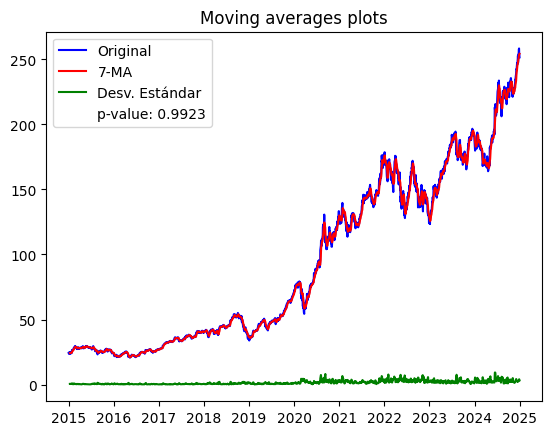

In [13]:
def moving_average(series, window_):
    mov_avg = series.rolling(window=window_).mean()
    mov_std = series.rolling(window=window_).std()

    # ADF Test
    df_test = adfuller(series.dropna(), autolag='AIC')
    p_value = df_test[1]
    df_out = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    if p_value <= 0.05:
        estacionaria = True
    else:
        estacionaria = False

    # Plot
    plt.title(f'Moving averages plots')
    plt.plot(series.index, series, color='blue', label='Original')
    plt.plot(series.index, mov_avg, color='red', label=f'{window_}-MA')
    plt.plot(series.index, mov_std, color='green', label='Desv. Estándar')
    plt.plot([], [], ' ', label=f'p-value: {p_value:.4f}')  # Línea vacía para leyenda

    plt.legend()
    
    return estacionaria

plt.tight_layout()
plt.show()

column = moving_average(df['Close'], 7,)

False

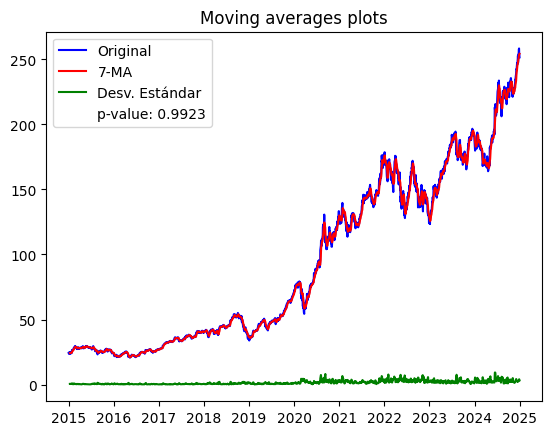

In [17]:
df_diff = df.copy()
moving_average(df_diff['Close'], 7)

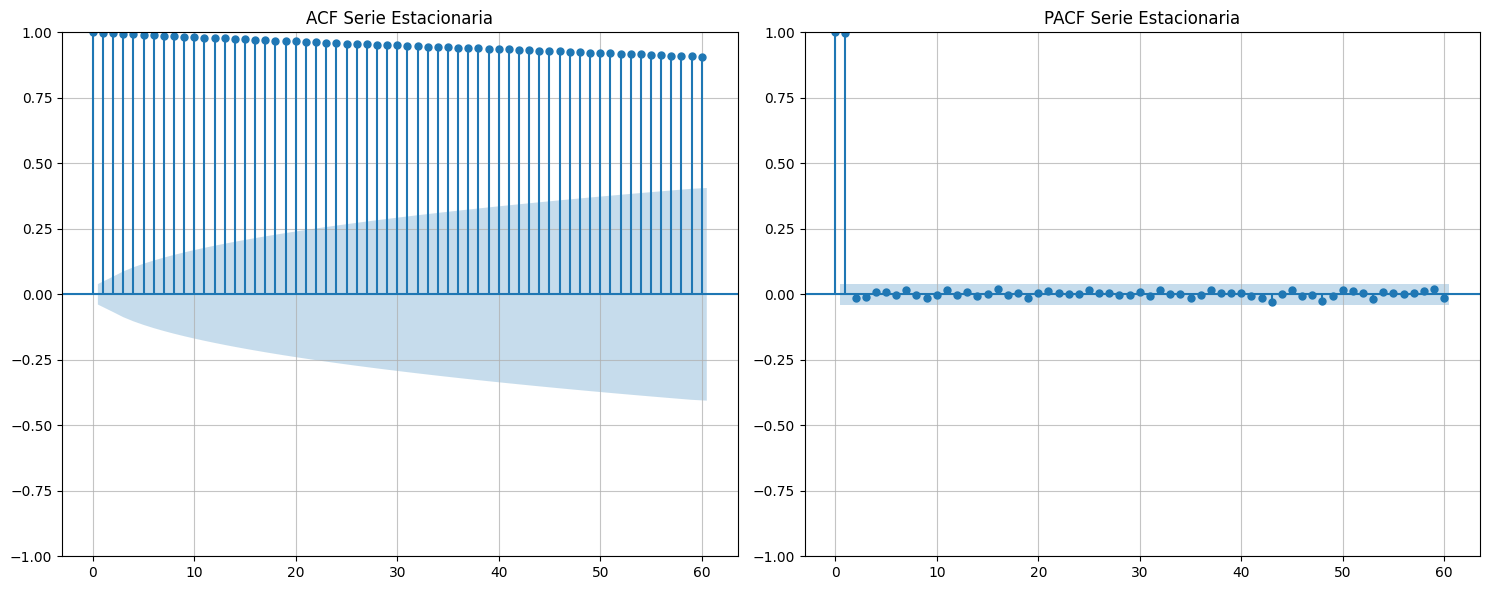

In [18]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plot_acf(df_diff['Close'].dropna(), lags=60, title="ACF Serie Estacionaria", ax=plt.gca())
plt.grid(alpha=0.75)

plt.subplot(122)
plot_pacf(df_diff['Close'].dropna(), lags=60, title="PACF Serie Estacionaria", method='ywm', ax=plt.gca())
plt.grid(alpha=0.75)

plt.tight_layout()
plt.show()


In [19]:
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge
pd.options.display.float_format = '{:.9f}'.format
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
from pytimetk import augment_timeseries_signature, augment_lags, augment_rolling, plot_timeseries
df_diff = df_diff.reset_index()
df_diff


Price,Date,Close
Ticker,,AAPL
0,2015-01-02,24.288579941
1,2015-01-05,23.604331970
2,2015-01-06,23.606554031
3,2015-01-07,23.937576294
4,2015-01-08,24.857303619
...,...,...
2510,2024-12-23,254.655715942
2511,2024-12-24,257.578674316
2512,2024-12-26,258.396667480


In [20]:
df_lags = augment_lags(df_diff, date_column='Date', value_column='Close', lags=[1, 2, 3, 7, 14])

# Mostrar el resultado
df_lags

Price,Date,Close,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_7,Close_lag_14
Ticker,,AAPL,,,,,
0,2015-01-02,24.288579941,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,23.604331970,24.288579941,NaN,NaN,NaN,NaN
2,2015-01-06,23.606554031,23.604331970,24.288579941,NaN,NaN,NaN
3,2015-01-07,23.937576294,23.606554031,23.604331970,24.288579941,NaN,NaN
4,2015-01-08,24.857303619,23.937576294,23.606554031,23.604331970,NaN,NaN
...,...,...,...,...,...,...,...
2510,2024-12-23,254.655715942,253.877593994,249.188888550,247.453079224,247.363296509,242.066070557
2511,2024-12-24,257.578674316,254.655715942,253.877593994,249.188888550,247.532882690,242.425201416
2512,2024-12-26,258.396667480,257.578674316,254.655715942,253.877593994,250.435867310,242.455123901


In [30]:
for w in [3, 7, 14, 30]:
    df_diff[f'rolling_mean_{w}'] = df_diff['Close'].rolling(window=w).mean()
    df_diff[f'rolling_std_{w}'] = df_diff['Close'].rolling(window=w).std()
    df_diff[f'rolling_max_{w}'] = df_diff['Close'].rolling(window=w).max()
    df_diff[f'rolling_min_{w}'] = df_diff['Close'].rolling(window=w).min()

In [32]:
df_diff.head(30)

Price,Date,Close,rolling_mean_3,rolling_std_3,rolling_max_3,rolling_min_3,rolling_mean_7,rolling_std_7,rolling_max_7,rolling_min_7,rolling_mean_14,rolling_std_14,rolling_max_14,rolling_min_14,rolling_mean_30,rolling_std_30,rolling_max_30,rolling_min_30
Ticker,,AAPL,,,,,,,,,,,,,,,,
0,2015-01-02,24.288579941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-05,23.604331970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-06,23.606554031,23.833155314,0.394410861,24.288579941,23.604331970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-07,23.937576294,23.716154099,0.191760465,23.937576294,23.604331970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-08,24.857303619,24.133811315,0.648054605,24.857303619,23.606554031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-01-09,24.883962631,24.559614182,0.538865499,24.883962631,23.937576294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-01-12,24.270805359,24.670690536,0.346567154,24.883962631,24.270805359,24.207016264,0.530445231,24.883962631,23.604331970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-01-13,24.486303329,24.547023773,0.311055766,24.883962631,24.270805359,24.235262462,0.540678055,24.883962631,23.604331970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-01-14,24.392993927,24.383367538,0.108071015,24.486303329,24.270805359,24.347928456,0.464030729,24.883962631,23.606554031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df_lags = df.copy()
FUERZA_BRUTA = list(range(10, 91))
for w in FUERZA_BRUTA:
    df_lags[f'lag{w}'] = df.shift(w)

df_lags = df_lags.fillna(0)
df_lags

Price,Close,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,lag31,lag32,lag33,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48,lag49,lag50,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60,lag61,lag62,lag63,lag64,lag65,lag66,lag67,lag68,lag69,lag70,lag71,lag72,lag73,lag74,lag75,lag76,lag77,lag78,lag79,lag80,lag81,lag82,lag83,lag84,lag85,lag86,lag87,lag88,lag89,lag90
Ticker,AAPL,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.288579941,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
2015-01-05,23.604331970,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
2015-01-06,23.606554031,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
2015-01-07,23.937576294,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.00000000

In [ ]:
K_SEMANAL = 3
K_MENSUAL = 4
K_60DIAS = 5
K_120DIAS = 5
K_180DIAS = 5
df_lags['time_idx'] =  np.arange(1, len(df_lags) + 1)
t = df_lags['time_idx']
# 1. Estacionalidad Semanal (P = 7 días)
P_semanal = 7
for k_val in range(1, K_SEMANAL + 1):
    df_lags[f'sin_sem_{k_val}'] = np.sin(2 * np.pi * k_val * df_lags['time_idx'] / P_semanal)
    df_lags[f'cos_sem_{k_val}'] = np.cos(2 * np.pi * k_val * df_lags['time_idx'] / P_semanal)

P_mensual = 365.25 / 12
for k_val in range(1, K_MENSUAL + 1):
    df_lags[f'sin_mens_{k_val}'] = np.sin(2 * np.pi * k_val * df_lags['time_idx'] / P_mensual)
    df_lags[f'cos_mens_{k_val}'] = np.cos(2 * np.pi * k_val * df_lags['time_idx'] / P_mensual)

# 3. Estacionalidad de 60 días (P = 60 días)
P_60dias = 60
for k_val in range(1, K_60DIAS + 1):
    df_lags[f'sin_60d_{k_val}'] = np.sin(2 * np.pi * k_val * df_lags['time_idx'] / P_60dias)
    df_lags[f'cos_60d_{k_val}'] = np.cos(2 * np.pi * k_val * df_lags['time_idx'] / P_60dias)

# 4. Estacionalidad de 120 días (P = 120 días)
P_120dias = 120
for k_val in range(1, K_120DIAS + 1):
    df_lags[f'sin_120d_{k_val}'] = np.sin(2 * np.pi * k_val * df_lags['time_idx'] / P_120dias)
    df_lags[f'cos_120d_{k_val}'] = np.cos(2 * np.pi * k_val * df_lags['time_idx'] / P_120dias)
'''
# 5. Estacionalidad de 180 días (P = 180 días)
P_180dias = 180
for k_val in range(1, K_180DIAS + 1):
    df_lags[f'sin_180d_{k_val}'] = np.sin(2 * np.pi * k_val * df_lags['time_idx'] / P_180dias)
    df_lags[f'cos_180d_{k_val}'] = np.cos(2 * np.pi * k_val * df_lags['time_idx'] / P_180dias)
'''
# También es común incluir una estacionalidad anual si los datos cubren más de un año
'''
P_anual = 365.25
K_ANUAL = 10 # Puede necesitar más términos para capturar bien la forma anual
for k_val in range(1, K_ANUAL + 1):
    df_lags[f'sin_anual_{k_val}'] = np.sin(2 * np.pi * k_val * df_lags['time_idx'] / P_anual)
    df_lags[f'cos_anual_{k_val}'] = np.cos(2 * np.pi * k_val * df_lags['time_idx'] / P_anual)
'''


"\nP_anual = 365.25\nK_ANUAL = 10 # Puede necesitar más términos para capturar bien la forma anual\nfor k_val in range(1, K_ANUAL + 1):\n    df_lags[f'sin_anual_{k_val}'] = np.sin(2 * np.pi * k_val * df_lags['time_idx'] / P_anual)\n    df_lags[f'cos_anual_{k_val}'] = np.cos(2 * np.pi * k_val * df_lags['time_idx'] / P_anual)\n"

In [87]:
int(len(df_lags)*0.85)

2137

In [98]:
lr = LinearRegression(fit_intercept = True)
df_train, df_test = df_lags.iloc[:int(len(df_lags)*0.85)], df_lags.iloc[int(len(df_lags)*0.85):]

y_train = df_train['Close']
X_train = df_train.drop(['Close'], axis = 1)

y_test = df_test['Close']
X_test = df_test.drop(['Close'], axis = 1)

print(f'La forma del df de train es: {X_train.shape}')
print(f'La forma del df de test es: {X_test.shape}')

La forma del df de train es: (2137, 116)
La forma del df de test es: (378, 116)


# Flujo sin Data Leakage

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

N_SPLITS_TSCV = 3
TEST_SIZE = 30
tscv = TimeSeriesSplit(n_splits=N_SPLITS_TSCV, test_size = TEST_SIZE)
sfs = SequentialFeatureSelector(
    estimator=lr,
    n_features_to_select='auto',  
    direction='forward',  
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)

sfs.fit(X_train, y_train)
selected_features = X_train.columns[sfs.get_support()]
print("Mejores retardos seleccionados para predecir a 30 días:", list(selected_features))

base_scores = cross_val_score(
    estimator=lr, # Usa la misma instancia de modelo que usó SFS si no lo modifica, o una nueva.
    X=X_train[selected_features],
    y=y_train,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
mean_base_score = np.mean(base_scores)
print(f"Score CV base (MAE): {-mean_base_score:.4f}")


Mejores retardos seleccionados para predecir a 30 días: [('lag10', ''), ('lag11', ''), ('lag12', ''), ('lag13', ''), ('lag14', ''), ('lag15', ''), ('lag16', ''), ('lag17', ''), ('lag18', ''), ('lag19', ''), ('lag20', ''), ('lag21', ''), ('lag22', ''), ('lag23', ''), ('lag24', ''), ('lag25', ''), ('lag26', ''), ('lag27', ''), ('lag28', ''), ('lag29', ''), ('lag30', ''), ('lag31', ''), ('lag32', ''), ('lag33', ''), ('lag35', ''), ('lag90', ''), ('time_idx', ''), ('sin_sem_1', ''), ('cos_sem_1', ''), ('sin_sem_2', ''), ('cos_sem_2', ''), ('sin_sem_3', ''), ('cos_sem_3', ''), ('sin_mens_1', ''), ('cos_mens_1', ''), ('sin_mens_2', ''), ('cos_mens_2', ''), ('sin_mens_3', ''), ('cos_mens_3', ''), ('sin_mens_4', ''), ('cos_mens_4', ''), ('sin_60d_1', ''), ('sin_60d_2', ''), ('cos_60d_2', ''), ('sin_60d_3', ''), ('sin_60d_4', ''), ('cos_60d_4', ''), ('sin_60d_5', ''), ('cos_60d_5', ''), ('sin_120d_1', ''), ('cos_120d_1', ''), ('sin_120d_2', ''), ('sin_120d_3', ''), ('cos_120d_3', ''), ('sin_120

In [101]:
# Obtener features seleccionadas
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
selected_features = X_train.columns[sfs.get_support()]

# Entrenar modelo con features seleccionadas
lr_final = LinearRegression(fit_intercept=True)
lr_final.fit(X_train[selected_features], y_train)

# Predecir en conjunto de test
y_pred = lr_final.predict(X_test[selected_features])

# Calcular métricas
r2_adj = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE en test: {mae:.4f}')
print(f'MAPE en test: {mape:.4f}')
print(f'R2_ADJ en test: {r2_adj:.4f}')

MAE en test: 7.2411
MAPE en test: 0.0366
R2_ADJ en test: 0.8603


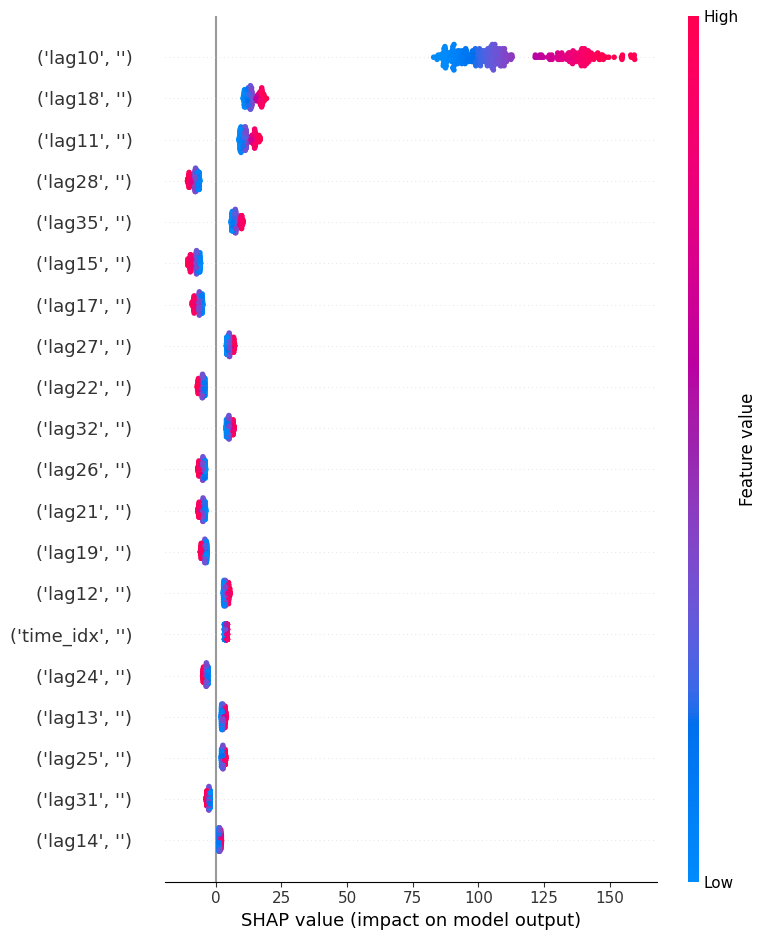

In [102]:
import shap
explainer = shap.Explainer(lr_final, X_train[selected_features])

# Calcular valores SHAP para el conjunto de test
shap_values = explainer(X_test[selected_features])

# Visualizar resumen de importancia global
shap.summary_plot(shap_values, X_test[selected_features])



In [106]:
# Obtener features seleccionadas
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
selected_features = X_train.columns[sfs.get_support()]

# Entrenar modelo con features seleccionadas
hubber_final = HuberRegressor(fit_intercept=True)
hubber_final.fit(X_train[selected_features], y_train)

# Predecir en conjunto de test
y_pred = hubber_final.predict(X_test[selected_features])

# Calcular métricas
r2_adj = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'MAE en test: {mae:.4f}')
print(f'MAPE en test: {mape:.4f}')
print(f'R2_ADJ en test: {r2_adj:.4f}')

MAE en test: 7.2773
MAPE en test: 0.0369
R2_ADJ en test: 0.8605


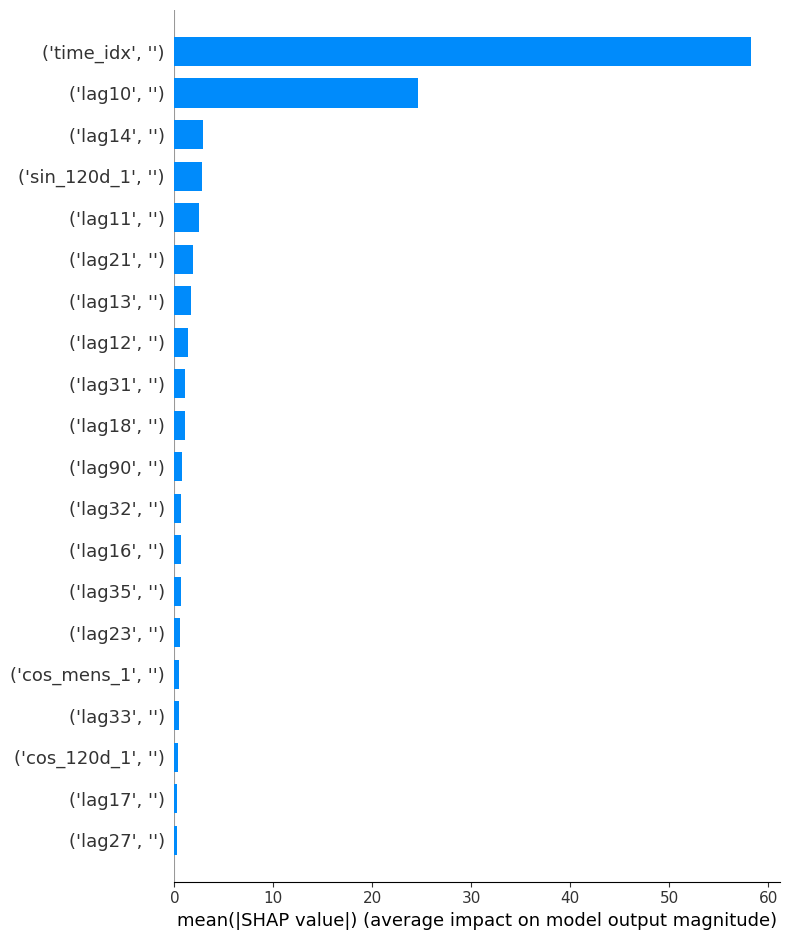

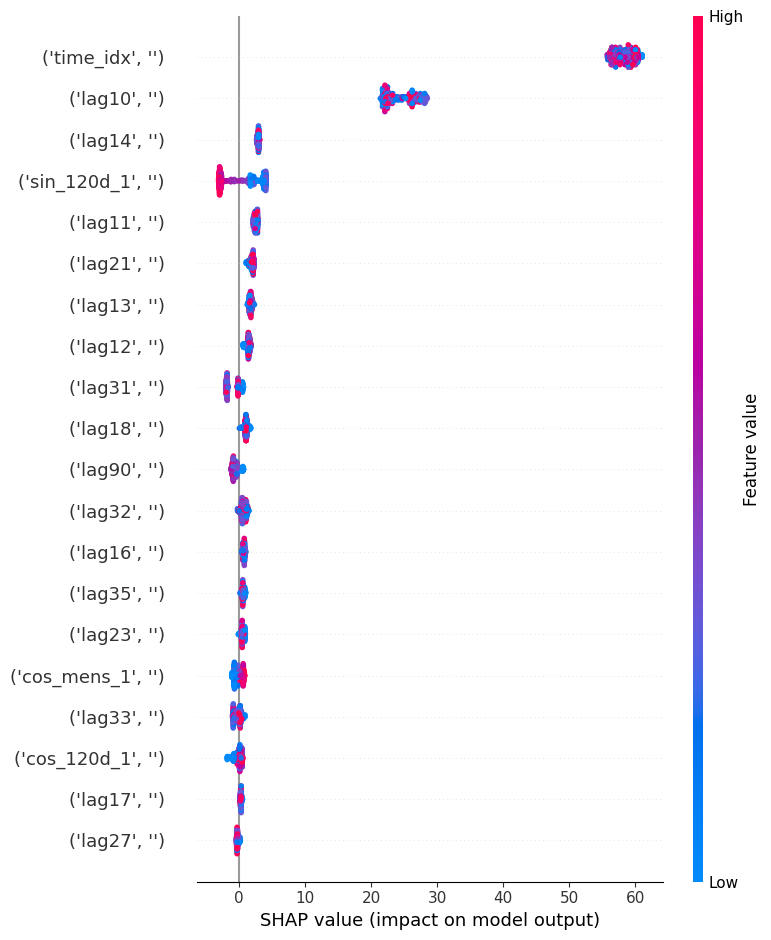

MAE en test: 28.0742
MAPE en test: 0.1312
R2_ADJ en test: -1.2537


In [105]:
model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train[selected_features], y_train)

# --- Explicación con SHAP ---

# Crear explainer de árbol
explainer = shap.TreeExplainer(model)

# Calcular valores SHAP para test
shap_values = explainer.shap_values(X_test[selected_features])

# Resumen global de importancia
shap.summary_plot(shap_values, X_test[selected_features], plot_type="bar")

# Gráfico de resumen detalle (beeswarm)
shap.summary_plot(shap_values, X_test[selected_features])

y_pred_xgb = model.predict(X_test[selected_features])

# Calcular métricas
r2_adj = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
mape = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f'MAE en test: {mae:.4f}')
print(f'MAPE en test: {mape:.4f}')
print(f'R2_ADJ en test: {r2_adj:.4f}')

